This notebook explores:
- The similarities between Aurora Avenue and Rainier Avenue
- Whether or not the number of collisions decreased after a traffic light was installed in certain locations
- Whether or not locations with a left turn signal have fewere accidents than locations without a left turn signal

In [1]:
from datetime import datetime, timezone

import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline


pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

alt.renderers.enable("mimetype")

import warnings

warnings.filterwarnings("ignore")

Read in data from the website Seattle City GIS

In [2]:
url = "https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"
rdf = pd.read_csv(url, parse_dates=["INCDTTM", "INCDATE"])

In [3]:
df = rdf.copy()

In [4]:
df.columns = map(str.lower, df.columns)

In [5]:
# Check that this date column is in the format that enables a comparison later 
# df['incdate'] = df['incdate'].dt.tz_localize('UTC')

In [6]:
# df.incdate[0]

In [7]:
df.head()

,x,y,objectid,inckey,coldetkey,reportno,status,addrtype,intkey,location,exceptrsncode,exceptrsndesc,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar
0,-122.353167,47.617308,1,336152,337652,EA85579,Unmatched,Block,NaN,1ST AVE BETWEEN BROAD ST AND EAGLE ST,,NaN,1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2020-11-02 00:00:00+00:00,2020-11-02 00:00:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
1,-122.330723,47.618492,2,332030,333530,3852424,Matched,Intersection,29168.0,DENNY WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2019-12-10 00:00:00+00:00,2019-12-10 20:43:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,52,Vehicle overturned,0,0,N
2,-122.355083,47.524706,3,332167,333667,M16001899,Unmatched,Intersection,35020.0,16TH AVE SW AND SW TRENTON ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016-01-28 00:00:00+00:00,2016-01-28 00:00:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
3,NaN,NaN,4,331686,333186,EA35334,Unmatched,NaN,NaN,NaN,NEI,"Not Enough Information, or Insufficient Locati...",0,Unknown,NaN,0,0,0,0,0,0,0,2020-05-21 00:00:00+00:00,2020-05-21 00:00:00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
4,-122.267542,47.502007,5,336029,337529,EA83212,Unmatched,Block,NaN,53RD AVE S BETWEEN S LEO ST AND S AVON ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020-11-21 00:00:00+00:00,2020-11-21 00:00:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y


In [8]:
df.shape

(223445, 40)

In [9]:
df.columns

Index(['x', 'y', 'objectid', 'inckey', 'coldetkey', 'reportno', 'status',
       'addrtype', 'intkey', 'location', 'exceptrsncode', 'exceptrsndesc',
       'severitycode', 'severitydesc', 'collisiontype', 'personcount',
       'pedcount', 'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries',
       'fatalities', 'incdate', 'incdttm', 'junctiontype', 'sdot_colcode',
       'sdot_coldesc', 'inattentionind', 'underinfl', 'weather', 'roadcond',
       'lightcond', 'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode',
       'st_coldesc', 'seglanekey', 'crosswalkkey', 'hitparkedcar'],
      dtype='object')

In [10]:
df.dtypes

x                              float64
y                              float64
objectid                         int64
inckey                           int64
coldetkey                        int64
reportno                        object
status                          object
addrtype                        object
intkey                         float64
location                        object
exceptrsncode                   object
exceptrsndesc                   object
severitycode                    object
severitydesc                    object
collisiontype                   object
personcount                      int64
pedcount                         int64
pedcylcount                      int64
vehcount                         int64
injuries                         int64
seriousinjuries                  int64
fatalities                       int64
incdate            datetime64[ns, UTC]
incdttm                 datetime64[ns]
junctiontype                    object
sdot_colcode             

In [11]:
pd.set_option("display.max_rows", 600)

### Create a subset of the dataframe to only contain incidents involving vehicles

**List st_coldesc categories**

In [12]:
labels = list(df['st_coldesc'].unique())
labels

[nan,
 'Vehicle overturned',
 'From same direction - both going straight - both moving - sideswipe',
 'One parked--one moving',
 'Entering at angle',
 'From same direction - both going straight - one stopped - rear-end',
 'Fixed object',
 'Vehicle turning right hits pedestrian',
 'One car leaving parked position',
 'Vehicle going straight hits pedestrian',
 'From same direction - one left turn - one straight',
 'From same direction - both going straight - both moving - rear-end',
 'From same direction - one right turn - one straight',
 'From same direction - both going straight - one stopped - sideswipe',
 'Vehicle Strikes Pedalcyclist',
 'Same direction -- both turning right -- both moving -- sideswipe',
 'From opposite direction - one left turn - one straight',
 'From opposite direction - all others',
 'From same direction - all others',
 'Pedalcyclist Strikes Moving Vehicle',
 'From opposite direction - both moving - head-on',
 'Vehicle turning left hits pedestrian',
 'From opposite

Select the labels to keep in the subset.

In [13]:
vehicle_only_labels = [
    label 
    for label in df['st_coldesc'].dropna().unique() 
    if label.startswith('From same direction')
    or label.startswith('From opposite direction')
    or label.startswith('One car')
    or label.startswith('One parked')
    or label.startswith('Vehicle overturned')
    or label.startswith('All Other Multi Vehicle')
    
]
vehicle_only_labels

['Vehicle overturned',
 'From same direction - both going straight - both moving - sideswipe',
 'One parked--one moving',
 'From same direction - both going straight - one stopped - rear-end',
 'One car leaving parked position',
 'From same direction - one left turn - one straight',
 'From same direction - both going straight - both moving - rear-end',
 'From same direction - one right turn - one straight',
 'From same direction - both going straight - one stopped - sideswipe',
 'From opposite direction - one left turn - one straight',
 'From opposite direction - all others',
 'From same direction - all others',
 'From opposite direction - both moving - head-on',
 'From opposite direction - both going straight - sideswipe',
 'From opposite direction - one left turn - one right turn',
 'One car entering parked position',
 'From opposite direction - one stopped - head-on',
 'One car leaving driveway access',
 'One car entering driveway access',
 'From opposite direction - both going stra

In [14]:
vehicle_only_df = df[df['st_coldesc'].isin(vehicle_only_labels)]
vehicle_only_df.shape

(128732, 40)

In [15]:
vehicle_only_df.head()

,x,y,objectid,inckey,coldetkey,reportno,status,addrtype,intkey,location,exceptrsncode,exceptrsndesc,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar
1,-122.330723,47.618492,2,332030,333530,3852424,Matched,Intersection,29168.0,DENNY WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2019-12-10 00:00:00+00:00,2019-12-10 20:43:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,52,Vehicle overturned,0,0,N
10,-122.297837,47.577939,11,335274,336774,EA75258,Matched,Block,NaN,RAINIER AVE S BETWEEN S MCCLELLAN ST AND S FOR...,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-10-25 00:00:00+00:00,2020-10-25 07:40:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dawn,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
13,-122.321935,47.677954,14,332148,333648,EA40509,Matched,Block,NaN,NE 68TH ST BETWEEN OSWEGO PL NE AND WEEDIN PL NE,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020-06-02 00:00:00+00:00,2020-06-02 13:20:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,32,One parked--one moving,0,0,Y
17,-122.313496,47.564827,18,332001,333501,EA38703,Matched,Block,NaN,15TH AVE S BETWEEN S NEVADA ST AND S COLUMBIAN...,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-06-07 00:00:00+00:00,2020-06-07 23:48:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
18,-122.298155,47.612933,19,335824,337324,EA76283,Matched,Block,NaN,E UNION ST BETWEEN 26TH AVE AND 27TH AVE,,NaN,2,Injury Collision,Rear Ended,3,0,0,3,1,0,0,2020-09-24 00:00:00+00:00,2020-09-24 12:43:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Raining,Wet,Daylight,NaN,NaN,Y,14,From same direction - both going straight - on...,0,0,N


<AxesSubplot:>

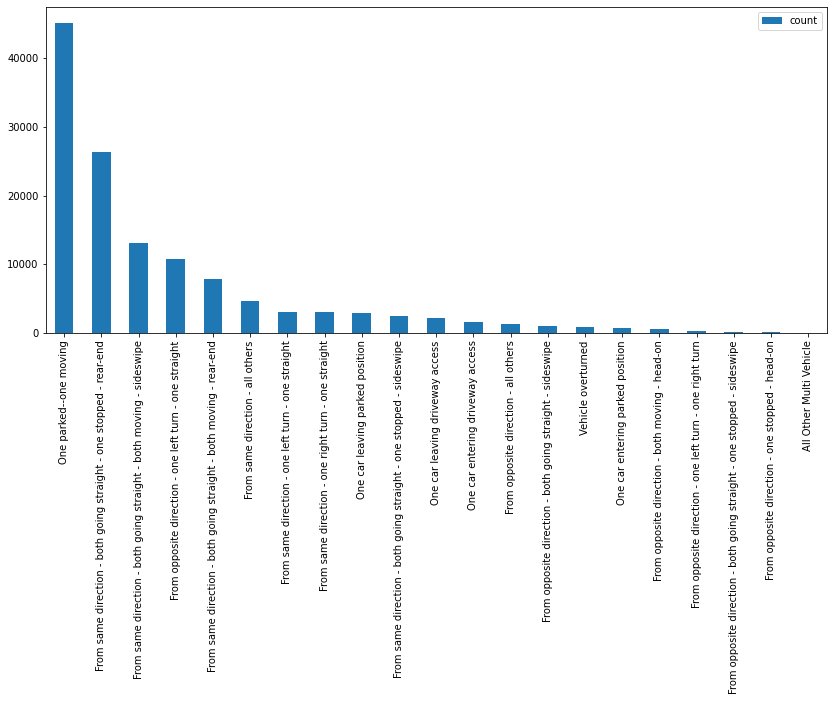

In [16]:
vehicle_only_df['st_coldesc'].value_counts().to_frame('count').plot.bar(figsize=(14, 6))

In [17]:
vehicle_only_df.rename(columns = {'objectid':'id'}).to_csv("../data/vehicle_only.csv")

vehicle_only_df.to_csv("../data/vehicle_only.csv")

For visualization of accidents involving vehicles only, click [here](https://public.tableau.com/profile/niwako.sugimura#!/vizhome/Seattlecollisiondatavehicletovehicleincidentsonly/Sheet1)

## Compare Rainier Ave and Aurora Ave in collision types and numbers

- Originally, we thought that the changes that have been made to Rainier Avenue may improve collisions happening on Aurora Avenue as well (we did not pursue this idea for the final dashboard).
- As a first step,  the two major roads are compared below in terms of types and number of collisions.

In [18]:
locations = list(df['location'].dropna().unique())

In [19]:
rainier_aurora_locations = [
    location
    for location in locations
    if "RAINIER AVE" in location or "AURORA AVE" in location
]
#rainier_aurora_locations[100:]

In [20]:
radf = vehicle_only_df[vehicle_only_df['location'].isin(rainier_aurora_locations)]
radf.head(10)

,x,y,objectid,inckey,coldetkey,reportno,status,addrtype,intkey,location,exceptrsncode,exceptrsndesc,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar
10,-122.297837,47.577939,11,335274,336774,EA75258,Matched,Block,NaN,RAINIER AVE S BETWEEN S MCCLELLAN ST AND S FOR...,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-10-25 00:00:00+00:00,2020-10-25 07:40:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dawn,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
23,-122.297837,47.577939,24,331890,333390,EA19236,Matched,Block,NaN,RAINIER AVE S BETWEEN S MCCLELLAN ST AND S FOR...,,NaN,1,Property Damage Only Collision,Rear Ended,3,0,0,2,0,0,0,2020-01-27 00:00:00+00:00,2020-01-27 20:29:00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N
45,-122.269988,47.529941,46,335302,336802,EA68405,Matched,Block,NaN,RAINIER AVE S BETWEEN S ELMGROVE ST AND S ROSE...,,NaN,2,Injury Collision,Rear Ended,4,0,0,4,1,0,0,2020-09-11 00:00:00+00:00,2020-09-11 23:08:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Fog/Smog/Smoke,Dry,Dark - Street Lights On,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N
53,-122.238949,47.510502,54,331951,333451,3856054,Matched,Block,NaN,RAINIER AVE S BETWEEN 75TH AVE S AND CITY LIMITS,,NaN,2,Injury Collision,Parked Car,2,0,0,2,1,0,0,2020-06-02 00:00:00+00:00,2020-06-02 10:48:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,32,One parked--one moving,0,0,N
67,-122.344962,47.721847,68,332052,333552,3855247,Matched,Block,NaN,AURORA AVE N BETWEEN N 127TH ST AND N 128TH ST,,NaN,2,Injury Collision,Right Turn,8,0,0,5,2,0,0,2020-06-05 00:00:00+00:00,2020-06-05 16:19:00,Driveway Junction,11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,16,From same direction - one right turn - one str...,0,0,N
111,-122.295910,47.575420,112,331786,333286,3852287,Matched,Block,NaN,RAINIER AVE S BETWEEN S MOUNT BAKER EB BV AND ...,,NaN,1,Property Damage Only Collision,Sideswipe,7,0,0,2,0,0,0,2020-06-01 00:00:00+00:00,2020-06-01 19:58:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,12,From same direction - both going straight - on...,0,0,N
137,-122.293225,47.571895,138,332143,333643,3838429,Matched,Intersection,32431.0,RAINIER AVE S AND S ESTELLE ST,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-06-17 00:00:00+00:00,2020-06-17 23:02:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
150,-122.285243,47.558252,151,331907,333407,EA38225,Matched,Block,NaN,RAINIER AVE S BETWEEN S EDMUNDS ST AND S FERDI...,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2020-06-06 00:00:00+00:00,2020-06-06 19:06:00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N
165,-122.288680,47.565899,166,335733,337233,EA73919,Matched,Block,NaN,RAINIER AVE S BETWEEN S DAKOTA ST AND S ADAMS ST,,NaN,2,Injury Collision,Head On,2,0,0,2,1,0,0,2020-03-06 00:00:00+00:00,2020-03-06 13:35:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEH

In [21]:
radf.shape

(11533, 40)

In [22]:
def recode(cell):
    if "RAINIER AVE" in cell:
        return "Rainier"
    if "AURORA AVE" in cell:
        return 'Aurora'
radf['road'] = radf['location'].fillna('missing').apply(recode)

In [23]:
radf.tail(10)

,x,y,objectid,inckey,coldetkey,reportno,status,addrtype,intkey,location,exceptrsncode,exceptrsndesc,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar,road
223123,-122.302928,47.584102,223124,329221,330721,3837929,Matched,Block,NaN,23RD AVE S BETWEEN RAINIER AVE S AND S WALKER ST,,NaN,1,Property Damage Only Collision,Rear Ended,4,0,0,2,0,0,0,2020-02-21 00:00:00+00:00,2020-02-21 18:02:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Dusk,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N,Rainier
223130,-122.343575,47.626706,223131,330573,332073,EA11998,Matched,Block,NaN,AURORA AVE N BETWEEN VALLEY ST AND ALOHA ST,,NaN,1,Property Damage Only Collision,Sideswipe,3,0,0,3,0,0,0,2020-01-21 00:00:00+00:00,2020-01-21 09:02:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Raining,Wet,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N,Aurora
223162,-122.295910,47.575420,223163,331604,333104,3838351,Matched,Block,NaN,RAINIER AVE S BETWEEN S MOUNT BAKER EB BV AND ...,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-05-22 00:00:00+00:00,2020-05-22 15:01:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N,Rainier
223166,-122.344997,47.725036,223167,330743,332243,EA29018,Matched,Block,NaN,AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,,NaN,1,Property Damage Only Collision,Sideswipe,4,0,0,4,0,0,0,2020-04-10 00:00:00+00:00,2020-04-10 11:53:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,12,From same direction - both going straight - on...,0,0,N,Aurora
223211,-122.344505,47.687304,223212,330608,332108,EA27733,Matched,Block,NaN,AURORA AVE N BETWEEN N 80TH ST AND N 81ST ST,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020-04-03 00:00:00+00:00,2020-04-03 10:59:00,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N,Aurora
223214,-122.269988,47.522816,223215,330578,332078,EA14642,Matched,Block,NaN,RAINIER AVE S BETWEEN S HENDERSON ST AND S DIR...,,NaN,1,Property Damage Only Collision,Rear Ended,4,0,0,2,0,0,0,2019-12-25 00:00:00+00:00,2019-12-25 22:30:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Overcast,Dry,Dark - Street Lights On,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N,Rainier
223236,-122.269988,47.532625,223237,328807,330307,3857202,Matched,Intersection,34493.0,RAINIER AVE S AND S CHICAGO ST,,NaN,2,Injury Collision,Left Turn,5,0,0,2,1,0,0,2020-02-06 00:00:00+00:00,2020-02-06 19:08:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N,Rainier
223248,-122.270433,47.537643,223249,330982,332482,EA30989,Matched,Intersection,34469.0,RAINIER AVE S AND S GARDEN ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2020-04-24 00:00:00+00:00,2020-04-24 13:05:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N,Rainier
223311,-122.290326,47.569769,223312,331609,333109,3838455,Matched,Block,NaN,S CHARLESTOWN ST BETWEEN RAINIER AVE S AND 34T...,,NaN,1

In [24]:
radf['road'].value_counts()

Rainier    6608
Aurora     4925
Name: road, dtype: int64

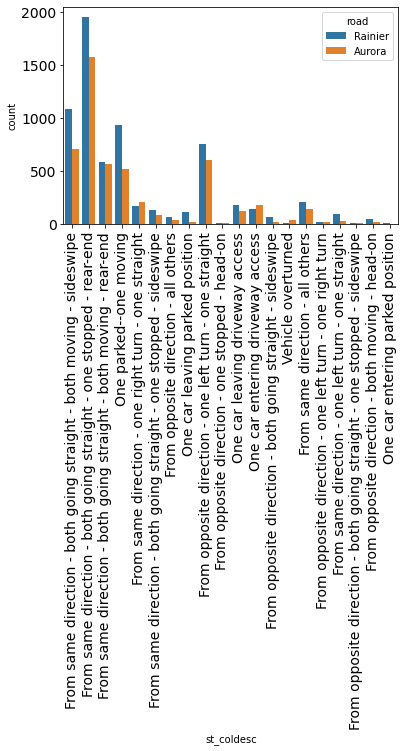

In [25]:
g = sns.countplot(x = 'st_coldesc',
             hue = 'road',
             data = radf)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.tick_params(labelsize=14);

- For both roads, 
   - `From same direction-both going straight-one stopped-rearending` is the most common type
    
   - `From same direction-both going straight-both moving-sideswipe`is the second most common type
- In general, the pattern is similar between the two roads
- Caveat: This pattern may be a general pattern; we may see the same pattern with other roads as well

## Merging with Traffic Signal Data

This section explores:

- Change in the number of collisions after a traffic light was installed in certain locations
- Difference in the number of collisions between locations with a left turn signal and locations without a left turn signal

To make date columns comparable between the collision data (`df`) and traffic signal data, first write a function to parse date columns for the traffic signal data.

In [26]:
date_parser = lambda x: pd.datetime.strptime(f'{x}00', '%Y/%m/%d %H:%M:%S%z')
date_parser('2018/05/22 00:00:00+00')

datetime.datetime(2018, 5, 22, 0, 0, tzinfo=datetime.timezone.utc)

In [27]:
date_cols = [
    "INSTALL_DATE",
    "ADDDTTM",
    "MODDTTM",
    "CONDITION_ASSESSMENT_DATE",
    "CURRENT_STATUS_DATE",
    "PEDHDFIRSTINSTALLDT",
    "PEDAUDIOINSTALLDT",
    "LTFIRSTINSTALLDT",
    "LTREMOVEDT",
    "RTFIRSTINSTALLDT",
    "RTREMOVEDT",
    "MMUINSTALLDT",
    "LASTSIGNALOPTDT",
    "PEDPSHINSTALLDT",
]
tsdf = pd.read_csv("../data/Traffic_Signals.csv", parse_dates=date_cols)

In [28]:
tsdf.columns = map(str.lower, tsdf.columns)
tsdf.head(3)

,objectid,compkey,comptype,unitid,description,unitdesc,segkey,intkey,int_unitid,signal_type,signal_maint_dist,install_date,adddttm,moddttm,ownership,condition,condition_assessment_date,current_status,current_status_date,arterial_class,maint_agree,maint_by,int_signal_type_cd,primarydistrictcd,secondarydistrictcd,pedaudiodeviceyn,pedsignalyn,ph_modeltype,pp_modeltype,pp_quantity,pedhdfirstinstalldt,ph_quantity,pedaudioinstalldt,bikesignalhdyn,asblt,halfsignalyn,meteredyn,ltturnsignalyn,ltprotectedpermyn,ltprotectedyn,rtturnsignalyn,rtprotectedpermyn,rtprotectedyn,ltfirstinstalldt,ltremovedt,rtfirstinstalldt,rtremovedt,detdevstopbaryn,detdevadvancedyn,detdevsystemyn,cabmodeltypecd,comconntypecd,mmumodeltypecd,pe_modeltype,pi_modeltype,installercd,jointownershipyn,co_modeltype,mmumancd,mmuinstalldt,lastsignaloptdt,pedpshinstalldt,num_attachments
0,1,272753,74,SGL-278,0.0,GREENWOOD AVE N AND N 80TH ST ...,1,24282,4521,SEMI,NORTH,1970-01-01 00:00:00+00:00,2005-03-17 17:11:06+00:00,2019-02-15 00:00:00+00:00,SDOT,GOOD,2008-03-06 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,2.0,NaN,,CITY,DISTRICT6,,N,N,LEDCD,NaN,NaN,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,Y,Y,N,N,N,N,2011-10-06 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,Y,N,N,3TS1,,NSM-12,NaN,NaN,,N,"LC8000, LMD9200",EDI,2019-02-12 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
1,2,272754,74,SGL-669,0.0,7TH AVE AND WESTLAKE AVE ...,1,29542,39139,PRE,DOWNTOWN,1970-01-01 00:00:00+00:00,2005-03-17 17:11:06+00:00,2020-07-02 00:00:00+00:00,SDOT,GOOD,2008-09-18 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,NaN,NaN,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,N,N,N,N,N,N,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,N,N,N,2,COPPER,NSM-12,OPT,NaN,,Y,"M34, , M52, M60-ATC, M60-ATC",EDI,2020-03-05 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
2,3,272755,74,SGL-178,0.0,2ND AVE AND BROAD ST ...,1,29666,39521,PRE,DOWNTOWN,1970-01-01 00:00:00+00:00,2005-03-17 17:11:06+00:00,2020-04-06 00:00:00+00:00,SDOT,POOR,2008-08-29 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,NAV-2W-PPB,8,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,N,N,N,N,N,N,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,N,N,N,3TS2-Type1,FIBER,MMU-16LEip,NaN,NaN,,Y,"M34, M60",EDI,2020-04-04 00:00:00+00:00,1970-01-01 00:00:00+00:00,2018-01-11 00:00:00+00:00,0


In [29]:
date_cols = [column.lower() for column in date_cols]
date_cols

['install_date',
 'adddttm',
 'moddttm',
 'condition_assessment_date',
 'current_status_date',
 'pedhdfirstinstalldt',
 'pedaudioinstalldt',
 'ltfirstinstalldt',
 'ltremovedt',
 'rtfirstinstalldt',
 'rtremovedt',
 'mmuinstalldt',
 'lastsignaloptdt',
 'pedpshinstalldt']

- Because the earliest date for the collision data included in our analysis was 2004, we can only take cases from the traffic signal data where the traffic signal was installed after 2004
- First get a feel for the signal installation dates

In [30]:
tsdf['install_date'].value_counts().sort_index()

1970-01-01 00:00:00+00:00    807
1977-10-01 00:00:00+00:00      1
1978-01-12 00:00:00+00:00      1
1978-02-02 00:00:00+00:00      1
1979-06-05 00:00:00+00:00      1
1980-12-08 00:00:00+00:00      1
1983-05-02 00:00:00+00:00      1
1986-02-26 00:00:00+00:00      1
1986-03-05 00:00:00+00:00      1
1986-04-03 00:00:00+00:00      1
1986-04-09 00:00:00+00:00      1
1986-06-18 00:00:00+00:00      1
1987-08-17 00:00:00+00:00      1
1987-11-25 00:00:00+00:00      1
1988-02-04 00:00:00+00:00      2
1988-02-08 00:00:00+00:00      1
1988-02-10 00:00:00+00:00      1
1988-05-15 00:00:00+00:00      1
1988-08-23 00:00:00+00:00      1
1988-08-31 00:00:00+00:00      1
1988-10-11 00:00:00+00:00      1
1988-11-30 00:00:00+00:00      1
1988-12-04 00:00:00+00:00      3
1988-12-08 00:00:00+00:00      1
1989-04-25 00:00:00+00:00      1
1989-05-03 00:00:00+00:00      1
1989-05-04 00:00:00+00:00      1
1989-06-15 00:00:00+00:00      1
1989-06-27 00:00:00+00:00      1
1989-07-06 00:00:00+00:00      1
1989-07-27

- Unfortunately the installation date is unknown for a lot of the signals

In [31]:
# How many intersections are included in the traffic signal data?
tsdf['intkey'].nunique()

1104

In [32]:
# Merge collision data and traffic signal data
dftsdf = pd.merge(df, tsdf, how='inner', left_on='intkey', right_on='intkey')

In [33]:
dftsdf.head()

,x,y,objectid_x,inckey,coldetkey,reportno,status,addrtype,intkey,location,exceptrsncode,exceptrsndesc,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,seglanekey,crosswalkkey,hitparkedcar,objectid_y,compkey,comptype,unitid,description,unitdesc,segkey,int_unitid,signal_type,signal_maint_dist,install_date,adddttm,moddttm,ownership,condition,condition_assessment_date,current_status,current_status_date,arterial_class,maint_agree,maint_by,int_signal_type_cd,primarydistrictcd,secondarydistrictcd,pedaudiodeviceyn,pedsignalyn,ph_modeltype,pp_modeltype,pp_quantity,pedhdfirstinstalldt,ph_quantity,pedaudioinstalldt,bikesignalhdyn,asblt,halfsignalyn,meteredyn,ltturnsignalyn,ltprotectedpermyn,ltprotectedyn,rtturnsignalyn,rtprotectedpermyn,rtprotectedyn,ltfirstinstalldt,ltremovedt,rtfirstinstalldt,rtremovedt,detdevstopbaryn,detdevadvancedyn,detdevsystemyn,cabmodeltypecd,comconntypecd,mmumodeltypecd,pe_modeltype,pi_modeltype,installercd,jointownershipyn,co_modeltype,mmumancd,mmuinstalldt,lastsignaloptdt,pedpshinstalldt,num_attachments
0,-122.330723,47.618492,2,332030,333530,3852424,Matched,Intersection,29168.0,DENNY WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2019-12-10 00:00:00+00:00,2019-12-10 20:43:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,52,Vehicle overturned,0,0,N,796,273605,74,SGL-117,0.0,DENNY WAY AND STEWART ST ...,1,36761,PRE,DOWNTOWN,1970-01-01 00:00:00+00:00,2005-03-17 17:14:07+00:00,2020-04-20 00:00:00+00:00,SDOT,FAIR,2008-09-16 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,STD,8,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,Y,N,Y,N,N,N,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,N,N,Y,6TS2,COPPER,MMU-16LEip,NaN,NaN,SDOT,N,"M34, M52, , M52, M52",EDI,2020-04-17 00:00:00+00:00,2008-03-31 00:00:00+00:00,1970-01-01 00:00:00+00:00,1
1,-122.330723,47.618492,3919,278000,278900,E780521,Matched,Intersection,29168.0,DENNY WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2018-03-16 00:00:00+00:00,2018-03-16 07:54:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Y,N,Clear,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N,796,273605,74,SGL-117,0.0,DENNY WAY AND STEWART ST ...,1,36761,PRE,DOWNTOWN,1970-01-01 00:00:00+00:00,2005-03-17 17:14:07+00:00,2020-04-20 00:00:00+00:00,SDOT,FAIR,2008-09-16 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,STD,8,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,Y,N,Y,N,N,N,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,N,N,Y,6TS2,COPPER,MMU-16LEip,NaN,NaN,SDOT,N,"M34, M52, , M52, M52",EDI,2020-04-17 00:00:00+00:00,2008-03-31 00:00:00+00:00,1970-01-01 00:00:00+00:00,1
2,-122.330723,47.618492,5008,16532,16532,3548987,Matched,Intersection,29168.0,DENNY WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2013-04-05 00:00:00+00:00,2013-04-05 07:07:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,N,Raining,Wet,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N,796,273605,74,SGL-117,0.0,DENNY WAY AND STEWART ST ...,1,36761,PRE,DOWNTOWN,1970-01-01 00:00:00+00:00,2005-03-17 17:14:07+00:00,2020-04-20 00:00:00+00:00,SDOT,FAIR,2008-09-16 00:00:00+00:00,INSVC,2008-12-15 00:00:00+00:00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,STD,8,1970-01-01 00:00:00+00:00,8,1970-01-01 00:00:00+00:00,N,NaN,N,N,Y,N,Y,N,N,N,1970-01-01 00:00:00+00:00,

In [34]:
dftsdf.shape

(36342, 102)

In [35]:
# Check how many intersections remained in the dataset
dftsdf['intkey'].nunique()

1084

<AxesSubplot:ylabel='install_date'>

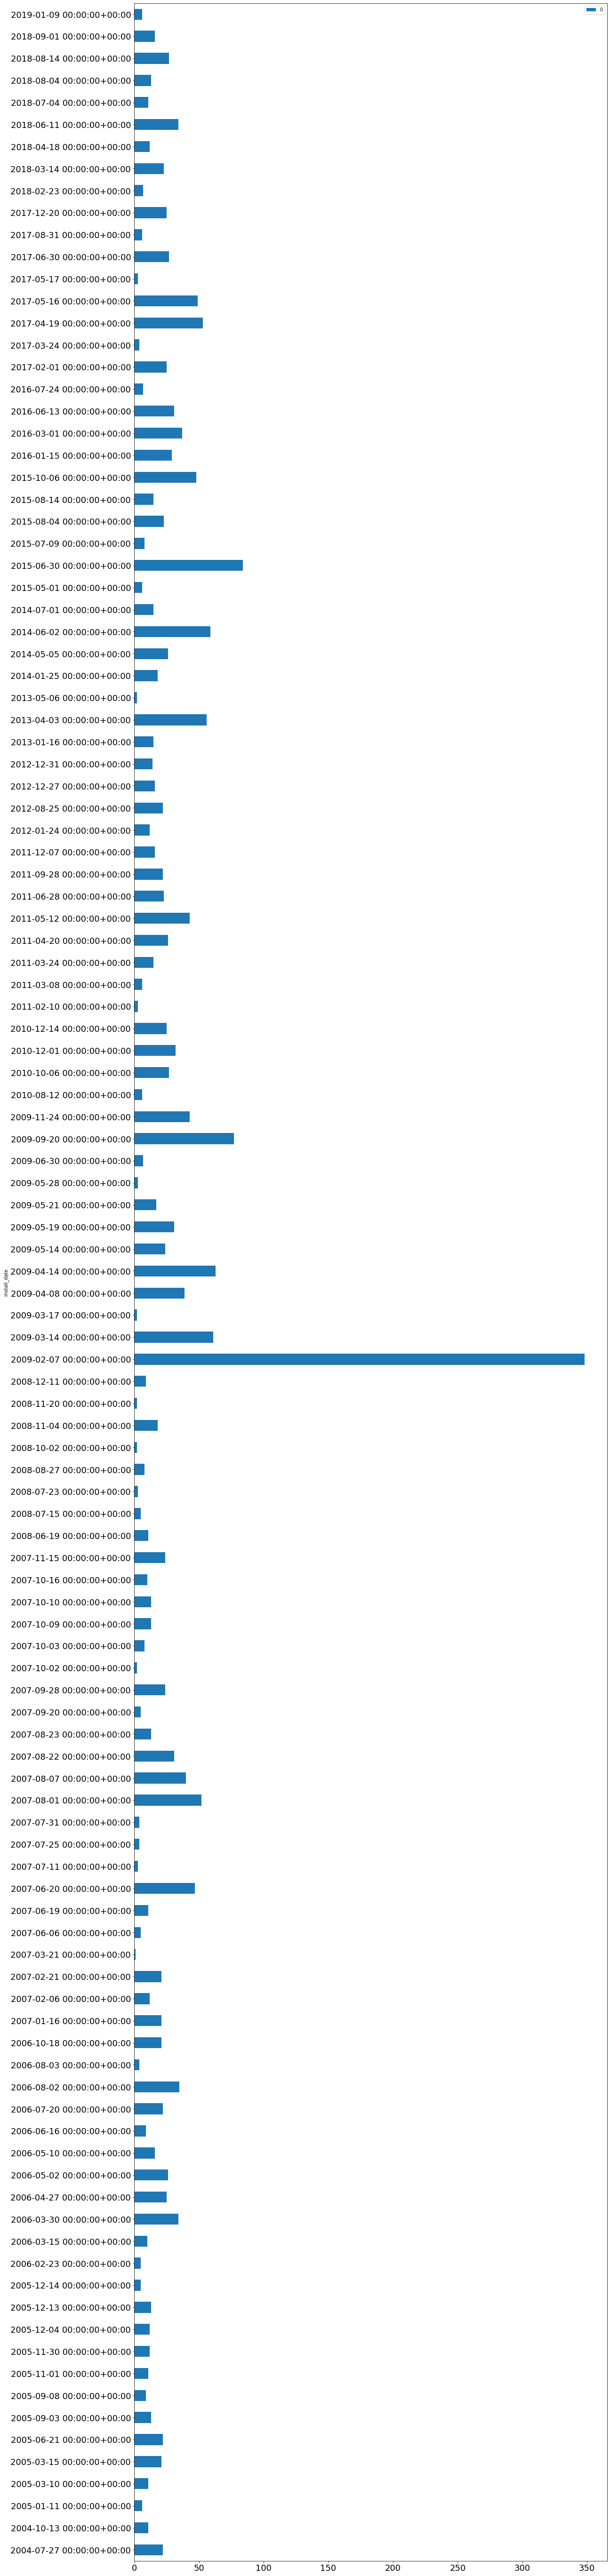

In [36]:
# Because the earliest year in the collision dataset is 2004, select cases in the merged datasets
# whose dates are 2004 or later
recentdf = dftsdf.loc[dftsdf['install_date'] >= '2004-01-01']
recentdf.groupby(['install_date']).size().to_frame().plot.barh(figsize=(18, 100), fontsize=18)

- It is strange that so many traffic lights were installed on 2009-02-07
- It may be that the information about these traffic lights were simply entered into the dataset on this date
- The chart below tested the possibility that the counts may even out somewhat if the count was summed across years rather than individual days

<AxesSubplot:>

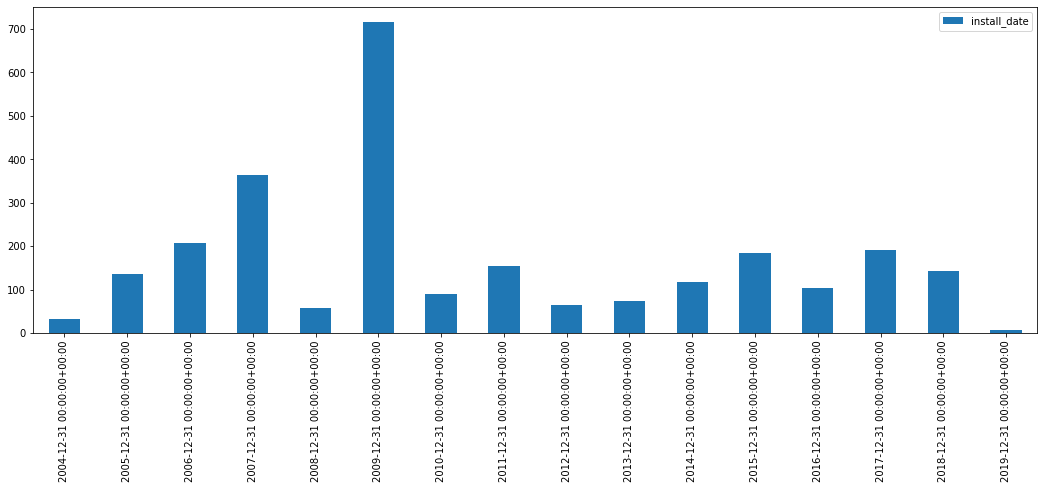

In [37]:
icdf = recentdf['install_date'].value_counts().sort_index().to_frame()
icdf = icdf.resample('Y').sum()
icdf.plot.bar(figsize=(18, 6))

- 2009 still seems to have an unusually high number of traffic lights installed
- There may be some error in this dataset

In [38]:
# Check again how many intersections remained in the dataset
recentdf['intkey'].nunique()

126

In [39]:
# True: the accident happened after the signal was installed
# False: the accident happened before the signal was installed
recentdf['has_signal'] = recentdf['incdate'] >= recentdf['install_date']

In [40]:
recentdf[['location', 'install_date', 'incdate', 'has_signal']]

,location,install_date,incdate,has_signal
1423,11TH AVE NW AND NW LEARY WAY,2004-07-27 00:00:00+00:00,2020-11-16 00:00:00+00:00,True
1424,11TH AVE NW AND NW LEARY WAY,2004-07-27 00:00:00+00:00,2013-06-27 00:00:00+00:00,True
1425,11TH AVE NW AND NW LEARY WAY,2004-07-27 00:00:00+00:00,2004-05-28 00:00:00+00:00,False
1426,11TH AVE NW AND NW LEARY WAY,2004-07-27 00:00:00+00:00,2004-03-31 00:00:00+00:00,False
1427,11TH AVE NW AND NW LEARY WAY,2004-07-27 00:00:00+00:00,2004-06-09 00:00:00+00:00,False
...,...,...,...,...
36335,M L KING JR ER WAY S AND S WILLOW ST,2007-08-01 00:00:00+00:00,2020-03-24 00:00:00+00:00,True
36336,M L KING JR WR WAY S AND S GENESEE ST,2007-10-02 00:00:00+00:00,2018-03-03 00:00:00+00:00,True
36337,M L KING JR WR WAY S AND S GENESEE ST,2007-10-02 00:00:00+00:00,2018-09-30 00:00:00+00:00,True
36339,DUWAMISH RIVER TRL AND WEST MARGINAL WAY SW,2009-03-17 00:00:00+00:00,2019-07-29 00:00:00+00:00,True


- Now, to test if the number of collisions declined after the traffic signal installation at each intersection, group collisions into before vs. after installation.
- To do that, set the beginning date (`start_date`) to the date of the collision with the earliest date.
- Set the ending date (`end_date`) to the date of the most recent collision. 
- Calculate the number of days before (`days_before_signal`) and after (`days_after_signal`) signal installation so the number of collisions can be normalized by the number of days for each period.
- This gives the number of collisions per day at each intersection for before and after the signal installation. 

In [41]:
recentdf['start_date'] = recentdf['incdate'].min()
recentdf['end_date'] = recentdf['incdate'].max()
recentdf['days_before_signal'] = recentdf['install_date'] - recentdf['start_date']
recentdf['days_after_signal'] = recentdf['end_date'] - recentdf['install_date']

In [42]:
recentdf.groupby(["location", "has_signal"]).size().to_frame("count").unstack().fillna(0)

count       
has_signal                                   False  True 
location                                                 
10TH AVE S AND S JACKSON ST                   25.0    2.0
11TH AVE NW AND NW LEARY WAY                   4.0   18.0
12TH AVE AND E MARION ST                       9.0    4.0
12TH AVE AND E SPRING ST                       9.0    2.0
12TH AVE NE AND NE CAMPUS WB PY                4.0    3.0
13TH AVE S AND AIRPORT WAY S                  10.0   30.0
13TH AVE S AND S ALBRO PL                     22.0    8.0
15TH AVE NE AND NE 120TH ST                    4.0   17.0
15TH AVE NW AND NW 53RD ST                    34.0    0.0
15TH AVE S AND S DAKOTA ST                     2.0   20.0
15TH AVE SW AND SW HOLDEN ST                   5.0    2.0
1ST AVE AND CLAY ST                           14.0    2.0
1ST AVE NW AND NW 36TH ST                     13.0    3.0
1ST AVE S AND RAILROAD N WAY S                 6.0    9.0
1ST AVE S AND S MASSACHUSETTS ST              12.0   20.0
22ND AVE AND E UNION ST                        6.0    9.0
23RD AVE AND E COLUMBIA ST                     9.0    4.0
23RD AVE AND E PINE ST                        15.0    3.0
23RD AVE S AND S KING ST                       1.0   10.0
28TH AVE NW AND NW MARKET ST                   0.0   11.0
2ND AVE AND BLANCHARD ST                      19.0    6.0
2ND AVE AND CEDAR ST                          40.0    4.0
2ND AVE AND CLAY ST                            3.0    0.0
2ND AVE AND VINE ST                            8.0    1.0
2ND AVE NE AND NE 100TH ST                     0.0    2.0
35TH AVE NE AND NE 94TH ST                     0.0    4.0
39TH AVE S AND RAINIER S AVE S                13.0    3.0
3RD AVE NE AND NE 103RD ST                     4.0   13.0
40TH AVE NE AND SAND POINT WAY NE             10.0    5.0
47TH AVE SW AND SW ADMIRAL WAY                 4.0    2.0
4TH AVE S AND S FOREST ST                      6.0    1.0
4TH AVE S AND W SEA BR EB 4 AV OFF RP          0.0    6.0
50TH AVE NE AND SAND POINT WAY NE              2.0    4.0
52ND AVE S AND RAINIER AVE S                   3.0    5.0
5TH AVE AND JEFFERSON ST                       7.0   14.0
5TH AVE NE AND NE 50TH ST                     13.0   26.0
5TH AVE S AND S WASHINGTON ST                  1.0   12.0
5TH AVE S AND S WELLER ST                      2.0    7.0
6TH AVE AND JAMES ST                         109.0  169.0
6TH AVE AND SPRING ST                         22.0   39.0
6TH AVE AND WESTLAKE AVE                       2.0   11.0
6TH AVE N AND HARRISON ST                      2.0    8.0
6TH AVE S AND S FOREST ST                      0.0   12.0
7TH AVE AND CHERRY ST                          1.0   20.0
7TH AVE AND JAMES ST                          17.0   53.0
7TH AVE AND SPRING ST                         21.0   10.0
7TH AVE N AND HARRISON ST                     19.0    8.0
7TH AVE NE AND NE 50TH ST                     19.0   44.0
9TH AVE N AND THOMAS ST                       22.0    1.0
AIRPORT WAY S AND S DORIS ST                   5.0    1.0
ALASKAN WAY AND BLANCHARD ST                   0.0    2.0
ALASKAN WAY AND SPRING ST                      2.0    7.0
ALASKAN WAY AND VINE ST                        0.0    3.0
ALASKAN WAY S AND S ATLANTIC ST               13.0   10.0
ALASKAN WAY S AND S DEARBORN ST                4.0    2.0
ALASKAN WAY S AND S KING ST                   35.0    8.0
AURORA AVE N AND N 92ND ST                    27.0    0.0
AURORA N AVE N AND N PHINNEY WAY              18.0    8.0
BEACON AVE S AND S LANDER ST                  10.0    2.0
BEACON AVE S AND S MCCLELLAN ST                1.0   20.0
BOREN AVE AND SPRING ST                        3.0    8.0
BOREN AVE N AND MERCER SR ST                  16.0    6.0
BRIDGE WAY N AND N 38TH ST                     6.0   10.0
BROADWAY AND XW E OLIVE ST                     1.0    1.0
BROADWAY E AND E ROANOKE ST                    3.0    1.0
CALIFORNIA AVE SW AND SW GENESEE ST            3.0   10.0
COLORADO AVE S AND S ATLANTIC ST           

In [43]:
crdf = (
    recentdf.groupby(["location", "has_signal"]) 
    # 'has_signal' = True after installation, False before installation 
    .size()
    .to_frame("count")
    .unstack()
    .fillna(0)
)
crdf = crdf.join(
    recentdf[["location", "days_before_signal", "days_after_signal"]]
    .drop_duplicates()
    .set_index("location")
)
crdf = crdf.rename({('count', False): 'before_count', ("count", True): "after_count"}, axis=1)
crdf["rate_before_signal"] = crdf.apply(
    lambda r: r["before_count"] / r["days_before_signal"].days, axis=1
)
crdf["rate_after_signal"] = crdf.apply(
    lambda r: r["after_count"] / r["days_after_signal"].days, axis=1
)
crdf.head()

,before_count,after_count,days_before_signal,days_after_signal,rate_before_signal,rate_after_signal
location,,,,,,
10TH AVE S AND S JACKSON ST,25.0,2.0,5327 days,837 days,0.004693,0.002389
11TH AVE NW AND NW LEARY WAY,4.0,18.0,196 days,5968 days,0.020408,0.003016
12TH AVE AND E MARION ST,9.0,4.0,5317 days,847 days,0.001693,0.004723
12TH AVE AND E SPRING ST,9.0,2.0,5286 days,878 days,0.001703,0.002278
12TH AVE NE AND NE CAMPUS WB PY,4.0,3.0,4576 days,1588 days,0.000874,0.001889


- `rate_before_signal` is number of collisions per day before the signal installation
- `rate_after_signal` is number of collisions per day after the signal installation

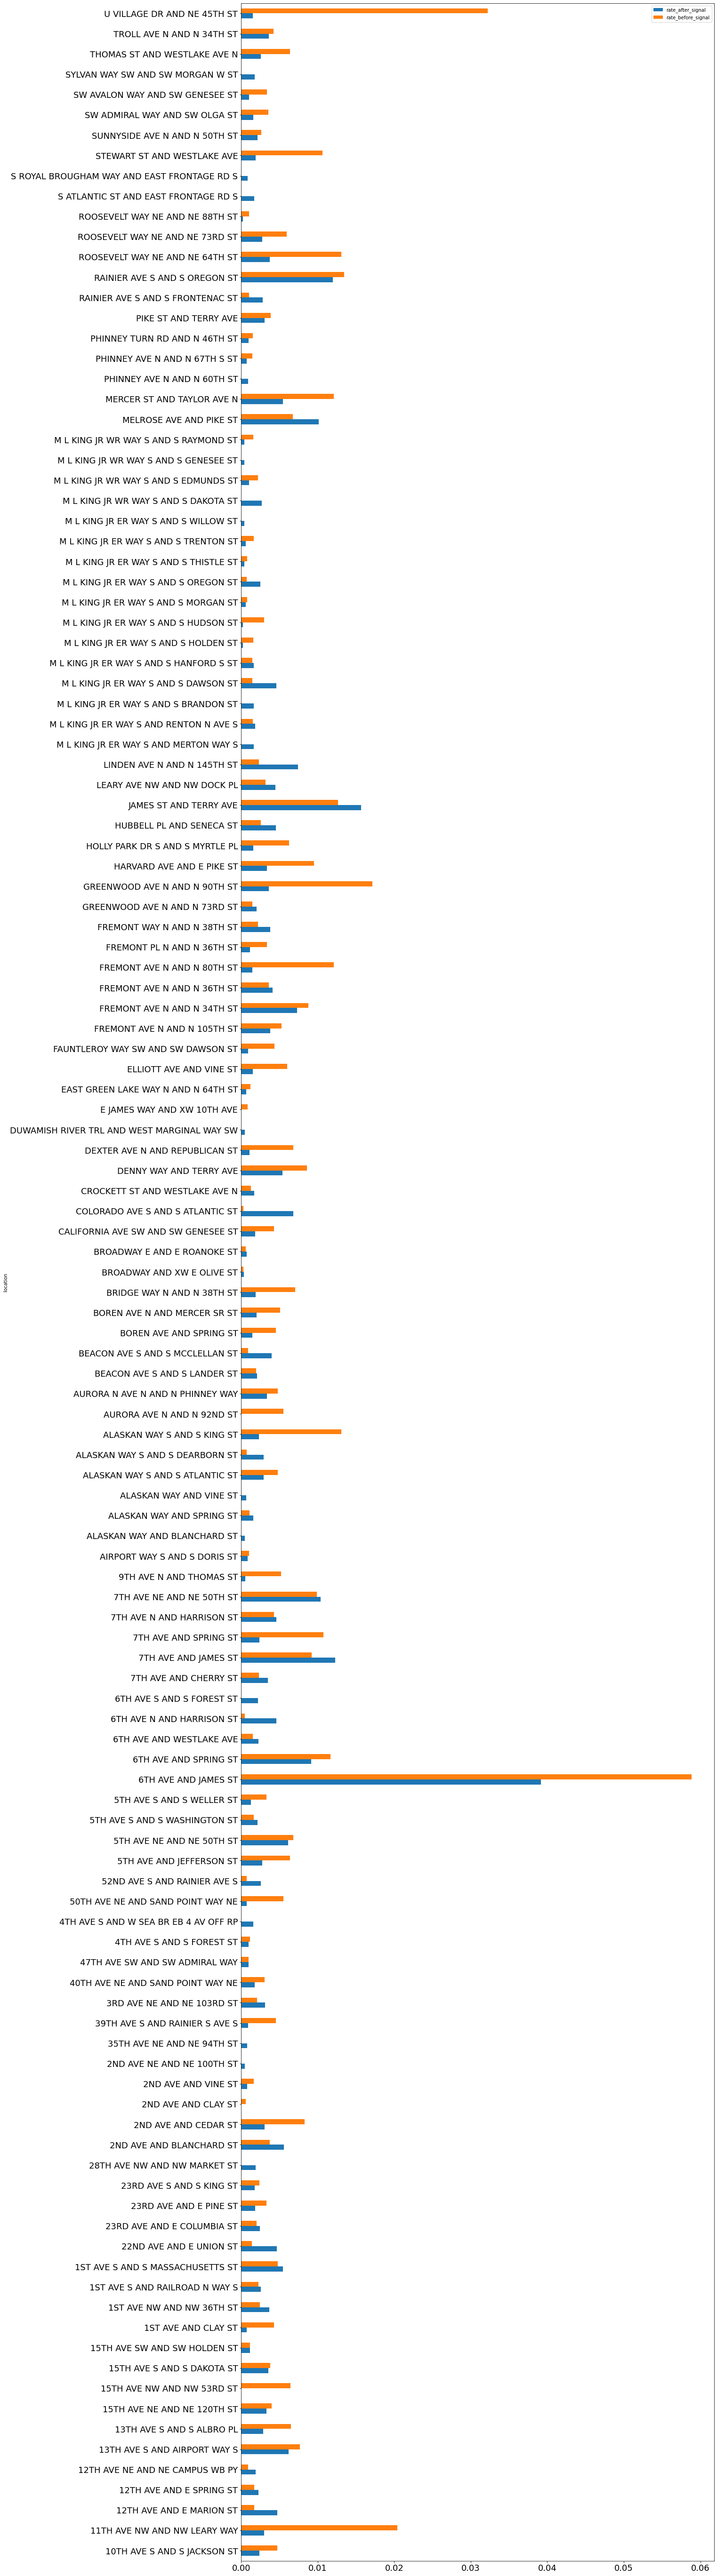

In [44]:
crdf.plot.barh(y=['rate_after_signal', 'rate_before_signal'], figsize=(18, 100), fontsize=18)
plt.savefig('before_and_after_signal.png', bbox_inches='tight')

- For the majority of the intersections, the number of accidents decreased after the installation of the signal
- But there are some intersections (e.g., James St. and Terry Ave.) where more accidents have happened after the installation of the signal
- Again it would be helpful to obtain data on the total traffic volume at each intersection 